# DataCronh

Autores: Aline Silva dos Santos, Jônatas Rafael de Oliveira Melo e Letícia Nunes de Souza Andrade.

### 1. Introdução

Este projeto foca na construção de um modelo preditivo supervisionado utilizando o conjunto de dados E-GEOD-101794, proveniente do repositório GEO. O objetivo central é induzir um modelo de Classificação Binária capaz de distinguir amostras de pacientes com Doença de Crohn ($y=1$) de controles não inflamatórios ($y=0$). As features ($X$) para esta tarefa são compostas pela expressão de $65.217$ genes, complementadas por metadados clínicos cruciais, como idade e sexo. <mark>CONTINUAR FORMULANDO INTRODUÇÃO COM CONTEXTUALIZAÇÃO/MODELOS/MÉTRICAS E AFINS.</mark>


### 2. Tratamento dos Dados

Nesta etapa será realizada a preparação dos dados, passo crucial capaz de transformar os dados brutos e incompatíveis em um formato estruturado e limpo que os algoritmos de Aprendizado de Máquina exigem. A estrura desse bloco seguirá da seguinte forma: 

* Carregamento e Inspeção dos dados - Para garantir que todos os dados estão acessíveis.
  
* Preparo da Matriz de Features Brutas (Transposição) - Mudança do formato de Genes x Amostras para Amostras x Genes (o formato esperado pelos modelos).

* Preparação do Target ($y$) e Metadados - Converte rótulos textuais (Crohn's disease) em numéricos (0/1) e limpa as features de metadados (Idade, Sexo)

* Merge Final - Alinha a expressão gênica bruta de cada amostra com seu rótulo de diagnóstico e suas características clínicas.

* Tranformação Logarítimica- O logaritmo comprime os valores mais altos, trazendo a distribuição para algo mais próximo da normal (Gaussiana). Isso evita que modelos sejam dominados por alguns outliers de alta expressão. Ou seja, melhora a distribuição estatística e trata a natureza multiplicativa dos dados biológicos.

* Normalização - Remove as diferenças de magnitude. Todos os genes e metadados log-transformados irão variar de forma igual, tipicamente entre 0 e 1.

* PCA - Empregado para reduzir a dimensionalidade do espaço das features para duas ou três componentes principais, facilitando a visualização e identificando os vetores de maior variância.

* Seleção de Features (Usando o df3/analytics.tsv) - Filtra os genes, criando um dataset final reduzido e otimizado (df_tratado) para a modelagem. A Seleção de Features é essencial para reduzir a dimensionalidade, mantendo genes significativos que atendem a $|\text{Log2FC}| \geq 1.0$ (significância biológica) e $\text{P-value} < 0.05$ (significância estatística) em pelo menos um subtipo (A1a ou A1b), preparando o conjunto final para os modelos.

#### 2.1 Bibliotecas Importadas:


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go


#### 2.2 Carregamento e Inspeção dos Dados:

In [27]:
dados_1 = "E-GEOD-101794-raw-counts.tsv"
dados_2 = "E-GEOD-101794-experiment-design.tsv"
dados_3 = "E-GEOD-101794-analytics.tsv"

# Carregar os DataFrames
df1 = pd.read_csv(dados_1, sep="\t")
df2 = pd.read_csv(dados_2, sep="\t")
df3 = pd.read_csv(dados_3, sep="\t")

# Inspeção dos Dados

# Contagens
print(f"\n[df1] Dimensões: {df1.shape}")
print("Primeiras linhas do df1:")
print(df1.head())

# Metadados
print(f"\n[df2] Dimensões: {df2.shape}")
print("Primeiras linhas do df2:")
print(df2[['Run', 'Sample Characteristic[disease]', 'Sample Characteristic[age at diagnosis]']].head())

# Resultados Estatísticos
print(f"\n[df3] Dimensões: {df3.shape}")
print("Primeiras linhas e colunas relevantes do df3:")
print(df3.iloc[:, :6].head(3))

# Verificação do número de amostras (Instâncias)
num_amostras_df1 = df1.shape[1] - 2  # Subtrai 'Gene ID' e 'Gene Name'
num_amostras_df2 = df2.shape[0]

print()
print(f"Amostras em df1: {num_amostras_df1}")
print(f"Amostras em df2: {num_amostras_df2}")

if num_amostras_df1 == num_amostras_df2:
    print("\nAs dimensões de amostra parecem consistentes para o merge.")
else:
    print("\nALERTA: O número de amostras não coincide. Uma verificação de quais amostras estão faltando será necessária no merge.")

# Armazenando o número de genes (features brutas)
num_genes = df1.shape[0]
print(f"Número de Features (Genes) Brutas: {num_genes}")


[df1] Dimensões: (65217, 306)
Primeiras linhas do df1:
           Gene ID Gene Name  SRR5861974  SRR5861975  SRR5861976  SRR5861977  \
0  ENSG00000000003    TSPAN6         385         809         251         873   
1  ENSG00000000005      TNMD           0           2           4           0   
2  ENSG00000000419      DPM1         292         300         182         482   
3  ENSG00000000457     SCYL3         122         146          64         329   
4  ENSG00000000460  C1orf112          12          37          27         111   

   SRR5861978  SRR5861979  SRR5861980  SRR5861981  ...  SRR5862268  \
0         644         460         498         308  ...         405   
1           1           5           3           1  ...           3   
2         289         227         369         229  ...         283   
3         242         150         315         136  ...         225   
4          28          42          99          48  ...          75   

   SRR5862269  SRR5862270  SRR5862271  SRR

#### 2.3 Preparo da Matriz de Features Brutas ($X$)

In [28]:
# Colunas de identificação e contagem
colunas_id = ['Gene ID', 'Gene Name']
colunas_contagem = [col for col in df1.columns if col not in colunas_id]

# Transposição e Indexação
df1_transposto = df1[colunas_contagem].T 

# Renomeando o Índice 
# O novo índice agora são os IDs das amostras (SRR...)
df1_transposto.index.name = 'Run' 

# Vamos usar o 'Gene ID' para renomear as colunas após a transposição
gene_ids = df1['Gene ID']
df1_transposto.columns = gene_ids

print(f"Dimensões da Matriz de Features Brutas (Amostras x Genes): {df1_transposto.shape}")
print()
print("Após transposição:")
print()
print(df1_transposto.iloc[:, :5].head())

Dimensões da Matriz de Features Brutas (Amostras x Genes): (304, 65217)

Após transposição:

Gene ID     ENSG00000000003  ENSG00000000005  ENSG00000000419  \
Run                                                             
SRR5861974              385                0              292   
SRR5861975              809                2              300   
SRR5861976              251                4              182   
SRR5861977              873                0              482   
SRR5861978              644                1              289   

Gene ID     ENSG00000000457  ENSG00000000460  
Run                                           
SRR5861974              122               12  
SRR5861975              146               37  
SRR5861976               64               27  
SRR5861977              329              111  
SRR5861978              242               28  


#### 2.4 Preparação do Target ($y$) e Metadados

In [29]:
# Seleciona as colunas a serem tratadas do df2
df = df2[['Run', 'Sample Characteristic[disease]', 
                          'Sample Characteristic[age at diagnosis]', 
                          'Sample Characteristic[sex]']].copy()

# Tranformações necessárias

# Codificação Binária para 'disease' (Target (y))
df.loc[:, 'Is_Crohns_Disease'] = (
    df['Sample Characteristic[disease]'] == "Crohn's disease").astype(int)

# Tratamento das Features: limpeza de Texto para 'age' e codificação categórica para 'sex'
df.loc[:, 'Patient_Age_Years'] = (
    df['Sample Characteristic[age at diagnosis]']
    .str.replace(' year', '', regex=False) # regex=False para otimização, já que o padrão é fixo
    .astype(float)
)

df.loc[:, 'Patient_Sex_Encoded'] = (
    df['Sample Characteristic[sex]']
    .astype('category') 
    .cat
    .codes
) # Se o output for {0: 'female', 1: 'male'}, sabemos que 0=female e 1=male


# Indexação e Seleção de Colunas Finais
df_final = df.set_index('Run')[['Is_Crohns_Disease', 'Patient_Age_Years', 'Patient_Sex_Encoded']]


# Pré-processamento dos metadados concluído:
print(f"Dimensões do DF de Metadados Final: {df_final.shape}")
print()
print(df_final.head())
print("\nVerificação do Balanceamento do Target (y):")
print(df_final['Is_Crohns_Disease'].value_counts())


Dimensões do DF de Metadados Final: (304, 3)

            Is_Crohns_Disease  Patient_Age_Years  Patient_Sex_Encoded
Run                                                                  
SRR5861974                  1                6.6                    1
SRR5861975                  1                6.8                    0
SRR5861976                  1                7.3                    0
SRR5861977                  1                7.8                    0
SRR5861978                  1                8.0                    0

Verificação do Balanceamento do Target (y):
Is_Crohns_Disease
1    254
0     50
Name: count, dtype: int64


#### 2.5 Alinhamento de amostras (Merge Final)

In [30]:
#Execuntando o alinhamento final e unificando os DataFrames

# Realiza o merge usando o índice ('Run') de ambos os DataFrames
df_final_unificado = df1_transposto.merge(
    df_final, 
    left_index=True, 
    right_index=True, 
    how='inner' # Garante que apenas amostras presentes em ambos os DFs permaneçam
)

print(f"Dimensões do DataFrame Final (Amostras x Features Totais): {df_final_unificado.shape}")
print()
colunas = df_final_unificado.columns[:5].tolist() + df_final_unificado.columns[-3:].tolist()
print(df_final_unificado[colunas].head())

# Separação de X (Features) e y (Target)
X_features = df_final_unificado.drop(columns=['Is_Crohns_Disease'])
y_target = df_final_unificado['Is_Crohns_Disease']

print(f"\nMatriz de Features Final (X) com: {X_features.shape[1]} colunas.")
print(f"Vetor Target (y_target) com: {y_target.shape[0]} exemplos.")
print()
df_final_unificado.iloc[:, :5]


Dimensões do DataFrame Final (Amostras x Features Totais): (304, 65220)

            ENSG00000000003  ENSG00000000005  ENSG00000000419  \
Run                                                             
SRR5861974              385                0              292   
SRR5861975              809                2              300   
SRR5861976              251                4              182   
SRR5861977              873                0              482   
SRR5861978              644                1              289   

            ENSG00000000457  ENSG00000000460  Is_Crohns_Disease  \
Run                                                               
SRR5861974              122               12                  1   
SRR5861975              146               37                  1   
SRR5861976               64               27                  1   
SRR5861977              329              111                  1   
SRR5861978              242               28                  1   

 

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460
Run,,,,,
SRR5861974,385,0,292,122,12
SRR5861975,809,2,300,146,37
SRR5861976,251,4,182,64,27
SRR5861977,873,0,482,329,111
SRR5861978,644,1,289,242,28
...,...,...,...,...,...
SRR5862273,296,0,302,188,85
SRR5862274,550,3,378,258,52
SRR5862275,457,2,325,175,52


#### 2.6 Normalização e Transformação Logarítmica dos dados

In [31]:
metadados = ['Patient_Age_Years', 'Patient_Sex_Encoded'] 
colunas_genes = X_features.columns.drop(metadados).tolist()

# Transformação Logarítmica 

# Aplicação do Log2(x + 1) apenas nas contagens de genes (reduz o peso de genes com expressão muito alta).
X_contagem_genes = X_features[colunas_genes].copy()
X_transformacao_log = np.log2(X_contagem_genes + 1)

# Reconstrução da Matriz (Log-Transformada + Metadados)
df_transformacao_log = pd.concat([
    X_transformacao_log, 
    X_features[metadados]
], axis=1)

print(f"Dimensões do DF Log-Transformado: {df_transformacao_log.shape}")

# Normalização dos dados

scaler = MinMaxScaler()
X_array_normalizado = scaler.fit_transform(df_transformacao_log[colunas_genes])

# Recriando o DataFrame Normalizado 
df_X_normalizado = pd.DataFrame(X_array_normalizado, 
                                columns=colunas_genes, 
                                index=df_transformacao_log.index)

# Reconstrução Final (Features normalizadas + metadados)
df_final_normalizado = pd.concat([
    df_X_normalizado,               # colunas de genes normalizadas
    df_transformacao_log[metadados] # colunas de metadados
], axis=1)

print(f"Dimensões do DF Final Normalizado e Log-Transformado: {df_final_normalizado.shape}")

Dimensões do DF Log-Transformado: (304, 65219)
Dimensões do DF Final Normalizado e Log-Transformado: (304, 65219)


#### 2.7 Redimensionamento dos dados


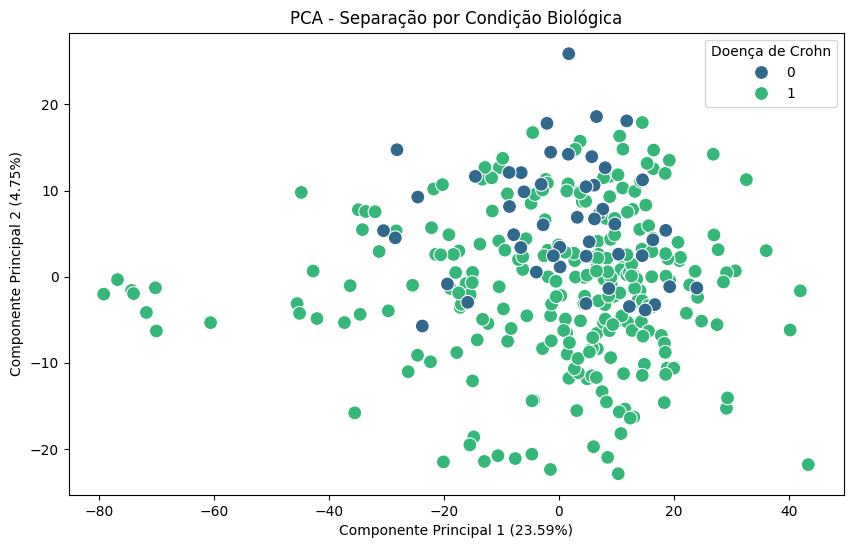

In [32]:
# Aplicação do PCA

X_pca_entrada = df_final_normalizado[colunas_genes]

pca = PCA(n_components=2)
componentes_principais = pca.fit_transform(X_pca_entrada)
df_pca = pd.DataFrame(data=componentes_principais, 
                      columns=['PC1', 'PC2'],
                      index=X_pca_entrada.index)

# Adicição do Target (y)
df_pca['Is_Crohns_Disease'] = y_target # Para colorir os pontos no gráfico conforme a condição biológica

# Plotagem (Visualização da Separação por Doença)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', 
                hue='Is_Crohns_Disease', 
                data=df_pca, 
                palette='viridis', 
                s=100)
plt.title('PCA - Separação por Condição Biológica')
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.legend(title='Doença de Crohn')
plt.show()

O gráfico apresenta a distribuição das amostras no espaço bidimensional das duas primeiras componentes principais (PC1 e PC2) obtidas pela Análise de Componentes Principais (PCA). As porcentagens nos eixos mostram a variância explicada por cada componente, ou seja, o quanto da variabilidade total dos dados é representada por essas direções principais.

Apesar de haver alguma sobreposição entre os grupos, observa-se uma leve tendência de separação ao longo do eixo PC1, sugerindo que essa componente carrega parte da informação que diferencia as duas condições biológicas.

##### 2.7.1 Aplicação do PCA 3D



In [33]:
# PCA 3D (Plotagem Interativa)

import plotly.io as pio
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import pandas as pd

# Renderização para a plotagem adequada do gráfico
pio.renderers.default = "vscode"  

# PCA 3D
pca_3d = PCA(n_components=3)
principais_componentes_3d = pca_3d.fit_transform(df_final_normalizado[colunas_genes])

df_pca_3d = pd.DataFrame(
    data=principais_componentes_3d,
    columns=['PC1', 'PC2', 'PC3'],
    index=df_final_normalizado.index
)

# Garantir que o Target é numérico (0 ou 1)
df_pca_3d['Is_Crohns_Disease'] = y_target.astype(int)

# Criação da figura 3D
fig = go.Figure(data=[go.Scatter3d(
    x=df_pca_3d['PC1'],
    y=df_pca_3d['PC2'],
    z=df_pca_3d['PC3'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_pca_3d['Is_Crohns_Disease'],
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Doença de Crohn (1=Sim, 0=Não)')
    )
)])

# Layout do gráfico
fig.update_layout(
    title=f'PCA 3D (Log-Normalizado) - Explica {pca_3d.explained_variance_ratio_.sum()*100:.2f}% da Variância',
    width=1000,
    height=800,
    scene=dict(
        xaxis=dict(title=f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.2f}%)'),
        yaxis=dict(title=f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.2f}%)'),
        zaxis=dict(title=f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.2f}%)'),
        aspectmode='data'
    )
)

fig.show()


O PCA 3D evidencia que as três primeiras componentes capturam parte da variabilidade global dos dados, mas não discriminam de forma clara as amostras com e sem Doença de Crohn. Isso sugere que a separação entre as condições pode depender de componentes posteriores ou de técnicas supervisionadas que utilizem o rótulo de classe.

#### 2.8 Seleção de Features

In [34]:
# Seleção de Features (Usando o df3/analytics.tsv)

LOG2FC_CORTE = 1.0 
P_VAL_CORTE = 0.05

# Nomes das colunas do df3 (Analytics TSV) 
print(f"Nomes das colunas do df3 (Analytics TSV): {df3.columns.tolist()}")
P_VAL_A1A = "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1a Paris classification'.p-value"
LOG_FC_A1A = "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1a Paris classification'.log2foldchange"
P_VAL_A1B = "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1b Paris classification'.p-value"
LOG_FC_A1B = "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1b Paris classification'.log2foldchange"
print()

# Aplica o filtro: Genes com p-value baixo e |Log2FC| alto em A1a ou em A1b
filter_a1a = (
    (df3[P_VAL_A1A] < P_VAL_CORTE) & 
    (df3[LOG_FC_A1A].abs() >= LOG2FC_CORTE)
)
filter_a1b = (
    (df3[P_VAL_A1B] < P_VAL_CORTE) & 
    (df3[LOG_FC_A1B].abs() >= LOG2FC_CORTE)
)

# Seleciona as linhas que passaram no filtro
genes_relevantes = df3[filter_a1a | filter_a1b]
genes_selecionados = genes_relevantes['Gene ID'].tolist()

print(f"Número de Features Brutas (Log/Normalizadas): {len(colunas_genes)}")
print(f"Número de Genes Selecionados (Após filtragem): {len(genes_selecionados)}")

# Cria a lista final de features (Genes selecionados + Metadados clínicos)
coluna_final = genes_selecionados + metadados

# Aplica a seleção no DF final normalizado (df_final_normalizado)
df_tratado = df_final_normalizado[coluna_final]

print(f"\nDimensões do DataFrame Final Pronto para Split/Treinamento: {df_tratado.shape}")

Nomes das colunas do df3 (Analytics TSV): ['Gene ID', 'Gene Name', "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1a Paris classification'.p-value", "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1a Paris classification'.log2foldchange", "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1b Paris classification'.p-value", "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1b Paris classification'.log2foldchange"]

Número de Features Brutas (Log/Normalizadas): 65217
Número de Genes Selecionados (Após filtragem): 1920

Dimensões do DataFrame Final Pronto para Split/Treinamento: (304, 1922)


##### 2.8.1 DataFrame Final Pronto para Split/Treinamento

In [35]:
df_tratado

,ENSG00000000005,ENSG00000000938,ENSG00000002549,ENSG00000003137,ENSG00000004809,ENSG00000005001,ENSG00000005073,ENSG00000005102,ENSG00000005381,ENSG00000005513,...,ENSG00000281383,ENSG00000281406,ENSG00000281491,ENSG00000281550,ENSG00000281571,ENSG00000281655,ENSG00000281756,ENSG00000281769,Patient_Age_Years,Patient_Sex_Encoded
Run,,,,,,,,,,,,,,,,,,,,,
SRR5861974,0.000000,0.392855,0.563267,0.350978,0.333333,0.514418,0.345036,0.126093,0.143227,0.605872,...,0.781611,0.442447,0.624084,0.00000,0.413544,0.308078,0.000000,0.156021,6.6,1
SRR5861975,0.329695,0.327785,0.571219,0.327968,0.333333,0.115355,0.309927,0.417438,0.090366,0.481417,...,0.472119,0.381103,0.362270,0.00000,0.500000,0.357668,0.224244,0.312042,6.8,0
SRR5861976,0.482995,0.573119,0.609590,0.532806,0.333333,0.548500,0.000000,0.559915,0.143227,0.507092,...,0.446811,0.725497,0.000000,0.00000,0.460391,0.000000,0.000000,0.695765,7.3,0
SRR5861977,0.000000,0.594237,0.722142,0.594027,0.210310,0.654343,0.000000,0.659157,0.090366,0.903573,...,0.297874,0.725497,0.247288,0.00000,0.500000,0.308078,0.672731,0.403309,7.8,0
SRR5861978,0.208015,0.367795,0.579770,0.489163,0.000000,0.439198,0.443405,0.510462,0.180732,0.749483,...,0.384997,0.659200,0.559330,0.17297,0.460391,0.398186,0.355418,0.156021,8.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR5862273,0.000000,0.448836,0.553786,0.574692,0.210310,0.399063,0.309927,0.466530,0.000000,0.843220,...,0.297874,0.302017,0.312042,0.27415,0.460391,0.244146,0.448488,0.247288,15.8,1
SRR5862274,0.416029,0.271883,0.561327,0.494692,0.333333,0.323843,0.133478,0.345258,0.090366,0.536132,...,0.418119,0.604034,0.403309,0.17297,0.356207,0.244146,0.579662,0.312042,15.8,1
SRR5862275,0.329695,0.215874,0.524290,0.604789,0.000000,0.439198,0.266957,0.345258,0.090366,0.399390,...,0.000000,0.534945,0.468063,0.00000,0.000000,0.790111,0.224244,0.000000,15.8,1


### 3. 

### 4. 

### 5. Discussão

<mark>FORMULAR CONCLUSÃO</mark>

### 6. Conclusão
<mark>FORMULAR CONCLUSÃO</mark>

### 7. Referências

1. Datasets https://www.ebi.ac.uk/gxa/experiments/E-GEOD-101794/Downloads
2. Transformação Logarítmica https://medium.com/@whzpvictoria/transforma%C3%A7%C3%A3o-logar%C3%ADtmica-nos-dados-quando-utilizar-d1a54da9beab
3. Normalização https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
4. PCA Johnson, R. A., & Wichern, D. W. (2007). Applied Multivariate Statistical Analysis (6th ed.). Pearson Prentice Hall.
5. Inspiração Gráfico PCA 3D https://github.com/mateusjmd/Ilum/tree/main/2025.2/PEST
6. Plotagem Gráficos PCA https://gemini.google.com/app
7. Significância Estatística ASSIS, Janilson Pinheiro de; SOUSA, Roberto Pequeno de; LINHARES, Paulo César Ferreira. Testes de Hipóteses Estatísticas. Mossoró, RN: EdUFERSA, 2020.
8. Significância Biológica LOVE, Michael I.; HUBER, Wolfgang; ANDERS, Simon. Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2. Genome Biology, v. 15, n. 12, p. 550, 2014.
9. Consultas https://gemini.google.com/app
10. <mark>COMPLETAR REFERÊNCIAS</mark>

_Observações:_ O Gemini foi utilizado como auxilio na identificação das etapas para o tratamento de dados e na elaboração dos códigos para realizar o tratamento, em especial para as formatações exibidas no console. Além de ser utilizado para a plotagem dos gráficos.